# 코로나 이후 매출증감 여부 모델

## #01. 패키지 설치

In [2]:
import sys
sys.path.append('../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("tdf.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권_코드        1009 non-null   int64  
 1   상권_코드_명      1009 non-null   object 
 2   점포수_x        1009 non-null   float64
 3   도심_x         1009 non-null   int64  
 4   총_직장_인구_수_x  1009 non-null   float64
 5   총_생활인구_수_x   1009 non-null   float64
 6   점포수_y        1009 non-null   float64
 7   총_직장_인구_수_y  1009 non-null   int64  
 8   총_생활인구_수_y   1009 non-null   float64
 9   매출증감         1009 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 79.0+ KB


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

상권_코드          0
상권_코드_명        0
점포수_x          0
도심_x           0
총_직장_인구_수_x    0
총_생활인구_수_x     0
점포수_y          0
총_직장_인구_수_y    0
총_생활인구_수_y     0
매출증감           0
dtype: int64

## #04. 탐색적 데이터 분석
> 앞 과정에서 이미 수행하였으므로 생략

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [5]:
np.random.seed(777)

### 훈련데이터(독립변수)와 레이블(종속변수) 구분하기

In [6]:
x = origin.drop(['상권_코드', '상권_코드_명', '매출증감'], axis=1)
x.head()

,점포수_x,도심_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,1,21133.770642,1.063927e+06,6.564356,13700,1.108208e+06
1,4.519231,1,10343.230769,3.304633e+06,4.493333,11773,3.704169e+06
2,7.094340,1,43510.654088,2.169122e+06,7.382550,39506,1.775981e+06
3,4.418182,1,8267.454545,2.516156e+06,4.390000,1696,3.109088e+06
4,3.263158,1,2711.131579,3.022949e+05,3.417910,4252,4.745286e+05


In [7]:
y = origin['매출증감']
y

0       0
1       0
2       0
3       0
4       0
       ..
1004    0
1005    1
1006    0
1007    0
1008    1
Name: 매출증감, Length: 1009, dtype: int64

### 데이터 표준화

#### 명목형 변수를 제거한 임시 데이터 생성

In [8]:
tmp = x.drop('도심_x', axis=1)
tmp

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,6.825688,21133.770642,1.063927e+06,6.564356,13700,1.108208e+06
1,4.519231,10343.230769,3.304633e+06,4.493333,11773,3.704169e+06
2,7.094340,43510.654088,2.169122e+06,7.382550,39506,1.775981e+06
3,4.418182,8267.454545,2.516156e+06,4.390000,1696,3.109088e+06
4,3.263158,2711.131579,3.022949e+05,3.417910,4252,4.745286e+05
...,...,...,...,...,...,...
1004,3.347826,1999.320652,4.004372e+06,3.603659,2122,5.776149e+06
1005,4.018072,4313.216867,7.342383e+05,4.311765,966,1.371762e+06
1006,5.335484,4582.309677,5.981897e+06,5.780303,2503,7.212605e+06
1007,4.771084,5432.831325,6.812592e+06,4.650685,6064,8.757489e+06


#### 임시 데이터프레임을 활용하여 표준화

In [9]:
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(tmp)
x_scale_df = DataFrame(x_scale, columns=tmp.columns, index=tmp.index)
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868
...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846


#### 표준화 결과에 명목형 변수를 결합

In [10]:
x_scale_df['도심'] = x['도심_x']
x_scale_df

,점포수_x,총_직장_인구_수_x,총_생활인구_수_x,점포수_y,총_직장_인구_수_y,총_생활인구_수_y,도심
0,1.466482,1.423805,-1.635368,1.082146,0.790915,-1.809769,1
1,0.114631,0.317615,-0.133935,-0.064296,0.578999,-0.461570,1
2,1.623943,3.717765,-0.894809,1.535069,3.628849,-1.462965,1
3,0.055405,0.104818,-0.662271,-0.121498,-0.529187,-0.770622,1
4,-0.621573,-0.464787,-2.145716,-0.659611,-0.248099,-2.138868,1
...,...,...,...,...,...,...,...
1004,-0.571948,-0.537758,0.334939,-0.556788,-0.482339,0.614503,0
1005,-0.179106,-0.300550,-1.856283,-0.164806,-0.609466,-1.672894,0
1006,0.593050,-0.272964,1.660022,0.648123,-0.440440,1.360518,0
1007,0.262246,-0.185773,2.216647,0.022808,-0.048830,2.162846,0


### 훈련데이터와 검증데이터 분할

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_scale_df, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((706, 7), (303, 7), (706,), (303,))

## #06. 모델개발

### 모델정의

In [12]:
len(x_scale_df.columns)

7

In [13]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(7, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [14]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=
                   [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001, verbose=1)])

Epoch 1/500
23/23 [==============================] - 1s 17ms/step - loss: 0.7061 - acc: 0.5099 - val_loss: 0.6911 - val_acc: 0.5347 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 0s 5ms/step - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6896 - val_acc: 0.5215 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6904 - acc: 0.5368 - val_loss: 0.6883 - val_acc: 0.5380 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 0s 5ms/step - loss: 0.6870 - acc: 0.5496 - val_loss: 0.6912 - val_acc: 0.5215 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 4ms/step - loss: 0.6860 - acc: 0.5538 - val_loss: 0.6905 - val_acc: 0.5347 - lr: 0.0010
Epoch 6/500
17/23 [=====================>........] - ETA: 0s - loss: 0.6849 - acc: 0.5588
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 [==============================] - 0s 5ms/step - loss: 0.6837 - acc: 0.5666 - val_loss: 0.6912 - val_acc: 0

## #07. 학습 결과 평가

In [18]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.706147,0.509915,0.691053,0.534653,0.0010
2,0.693429,0.500000,0.689561,0.521452,0.0010
3,0.690399,0.536827,0.688320,0.537954,0.0010
4,0.686957,0.549575,0.691227,0.521452,0.0010
5,0.686040,0.553824,0.690491,0.534653,0.0010
6,0.683724,0.566572,0.691231,0.534653,0.0010
7,0.682052,0.556657,0.691181,0.531353,0.0005
8,0.681295,0.558074,0.690152,0.534653,0.0005


In [19]:
column_names = result_df.columns
column_names

Index(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], dtype='object')

In [20]:
train_column_name = [column_names[0], column_names[1]]
test_column_name = [column_names[2], column_names[3]]

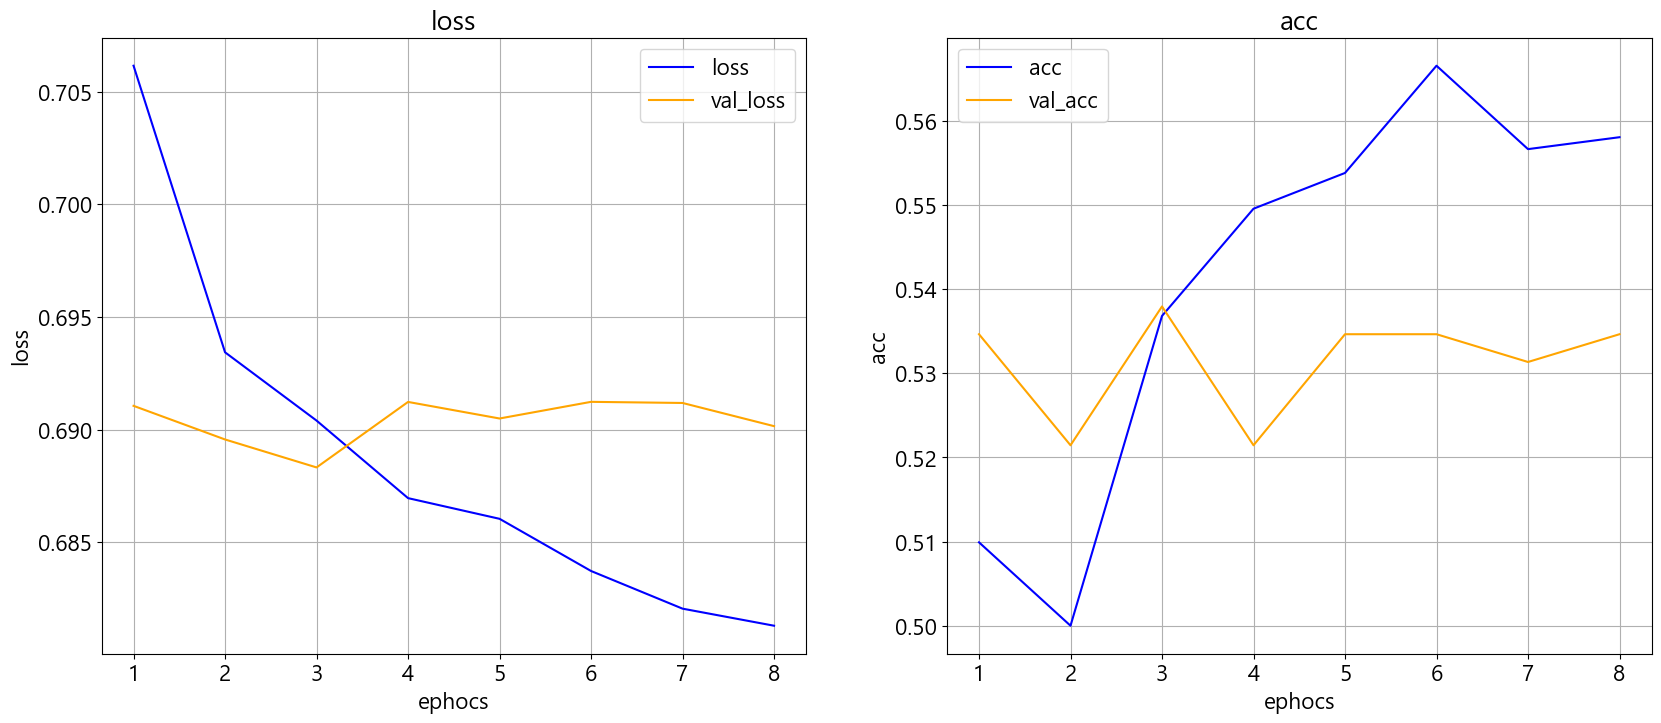

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()